## Topic Modeling: Latent Dirichlet Allocation with gensim

### Imports

In [6]:
import warnings
from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd

# Visualization
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import pyLDAvis
from pyLDAvis.sklearn import prepare

from wordcloud import WordCloud
from termcolor import colored

# spacy for language processing
import spacy

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

# gensim for alternative models
from gensim.models import LdaModel, LdaMulticore
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus

/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [10]:
% matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14.0, 8.7)
pyLDAvis.enable_notebook()
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

## Load BBC data

In [11]:
path = Path('bbc')
files = path.glob('**/*.txt')
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        _, topic, file_name = file.parts

        lines = f.readlines()
        file_id = file_name.split('.')[0]
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic, heading, body])

### Convert to DataFrame

In [12]:
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
topic      2225 non-null object
heading    2225 non-null object
article    2225 non-null object
dtypes: object(3)
memory usage: 52.2+ KB


## Create Train & Test Sets

In [32]:
train_docs, test_docs = train_test_split(docs, 
                                         stratify=docs.topic, 
                                         test_size=50, 
                                         random_state=42)

In [33]:
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [34]:
pd.Series(test_docs.topic).value_counts()

sport            12
business         11
politics          9
entertainment     9
tech              9
Name: topic, dtype: int64

### Vectorize train & test sets

In [35]:
vectorizer = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words='english', 
                             max_features=2000)

train_dtm = vectorizer.fit_transform(train_docs.article)
words = vectorizer.get_feature_names()
train_dtm

<2175x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 178873 stored elements in Compressed Sparse Row format>

In [36]:
test_dtm = vectorizer.transform(test_docs.article)
test_dtm

<50x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 3890 stored elements in Compressed Sparse Row format>

## LDA with gensim

### Using `CountVectorizer` Input

In [86]:
max_df = .2
min_df = 3
max_features = 2000

# used by sklearn: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/stop_words.py
stop_words = pd.read_csv('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words', 
                         header=None, 
                         squeeze=True).tolist()

In [87]:
vectorizer = CountVectorizer(max_df=max_df, 
                             min_df=min_df, 
                             stop_words='english', 
                             max_features=max_features)

train_dtm = vectorizer.fit_transform(train_docs.article)
test_dtm = vectorizer.transform(test_docs.article)

In [88]:
train_corpus = Sparse2Corpus(train_dtm, documents_columns=False)
test_corpus = Sparse2Corpus(test_dtm, documents_columns=False)

id2word = pd.Series(vectorizer.get_feature_names()).to_dict()

### Train Model & Review Results

In [89]:
lda_gensim = LdaModel(corpus=train_corpus,
                          num_topics=5,
                          id2word=id2word)

In [90]:
topics = lda_gensim.print_topics()
topics[0]

(0,
 '0.016*"best" + 0.009*"united" + 0.008*"glazer" + 0.007*"club" + 0.006*"film" + 0.005*"game" + 0.004*"women" + 0.004*"award" + 0.004*"awards" + 0.004*"won"')

### Evaluate Topic Coherence

Topic Coherence measures whether the words in a topic tend to co-occur together. 

- It adds up a score for each distinct pair of top ranked words. 
- The score is the log of the probability that a document containing at least one instance of the higher-ranked word also contains at least one instance of the lower-ranked word.

Large negative values indicate words that don't co-occur often; values closer to zero indicate that words tend to co-occur more often.

In [91]:
coherence = lda_gensim.top_topics(corpus=train_corpus, coherence='u_mass')

  Topic 1           Topic 2           Topic 3        Topic 4          Topic 5        
     prob      term    prob      term    prob   term    prob     term    prob    term
0   0.87%    labour   0.71%      lord   0.68%   game   0.80%     game   1.56%    best
1   0.70%  election   0.57%      home   0.58%   play   0.54%      win   0.90%  united
2   0.66%     brown   0.56%     music   0.58%   film   0.46%      won   0.81%  glazer
3   0.66%       tax   0.45%  internet   0.53%  music   0.46%     half   0.71%    club
4   0.56%   economy   0.44%   digital   0.50%  games   0.45%  england   0.58%    film


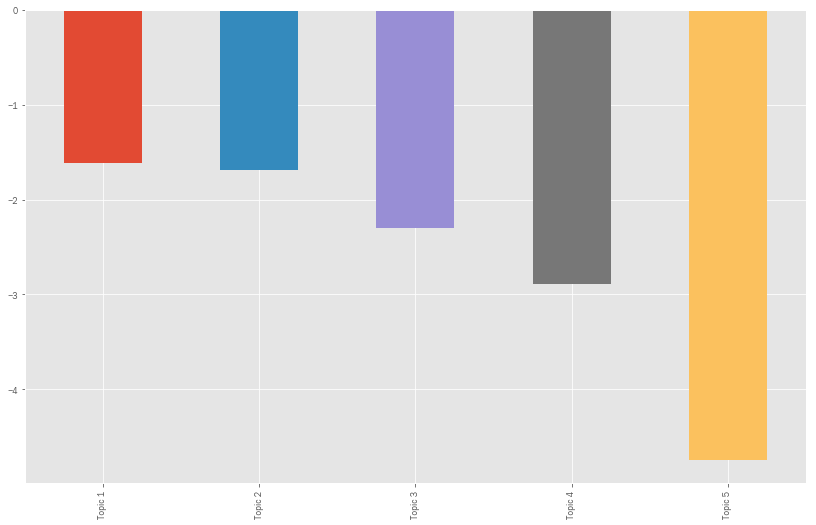

In [92]:
topic_coherence = []
topic_words = pd.DataFrame()
for t in range(len(coherence)):
    label = topic_labels[t]
    topic_coherence.append(coherence[t][1])
    df = pd.DataFrame(coherence[t][0], columns=[(label, 'prob'), (label, 'term')])
    df[(label, 'prob')] = df[(label, 'prob')].apply(lambda x: '{:.2%}'.format(x))
    topic_words = pd.concat([topic_words, df], axis=1)
                      
topic_words.columns = pd.MultiIndex.from_tuples(topic_words.columns)
pd.set_option('expand_frame_repr', False)
print(topic_words.head())
pd.Series(topic_coherence, index=topic_labels).plot.bar();

### Using `gensim` `Dictionary` 

In [93]:
docs = [d.split() for d in train_docs.article.tolist()]
docs = [[t for t in doc if t not in stop_words] for doc in docs]

In [94]:
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=min_df, no_above=max_df, keep_n=max_features)

In [95]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [96]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2000
Number of documents: 2175


In [97]:
num_topics = 5
chunksize = 500
passes = 20
iterations = 400
eval_every = None # Don't evaluate model perplexity, takes too much time.

temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

In [98]:
%%time
model = LdaModel(corpus=corpus,
                 id2word=id2word,
                 chunksize=chunksize,
                 alpha='auto',
                 eta='auto',
                 iterations=iterations,
                 num_topics=num_topics,
                 passes=passes, 
                 eval_every=eval_every)

CPU times: user 27 s, sys: 153 ms, total: 27.2 s
Wall time: 27.3 s


In [99]:
model.show_topics()

[(0,
  '0.017*"music" + 0.012*"mobile" + 0.010*"games" + 0.010*"digital" + 0.009*"game" + 0.009*"technology" + 0.009*"video" + 0.006*"TV" + 0.006*"phones" + 0.005*"play"'),
 (1,
  '0.019*"best" + 0.013*"film" + 0.011*"won" + 0.009*"British" + 0.007*"world" + 0.006*"years" + 0.005*"director" + 0.005*"star" + 0.005*"band" + 0.005*"took"'),
 (2,
  '0.007*"government" + 0.006*"market" + 0.006*"economic" + 0.006*"company" + 0.006*"growth" + 0.006*"economy" + 0.005*"sales" + 0.005*"chief" + 0.005*"rise" + 0.005*"oil"'),
 (3,
  '0.010*"use" + 0.009*"used" + 0.008*"users" + 0.007*"net" + 0.007*"information" + 0.007*"using" + 0.006*"phone" + 0.006*"security" + 0.006*"software" + 0.006*"internet"'),
 (4,
  '0.008*"Labour" + 0.006*"Blair" + 0.005*"government" + 0.005*"England" + 0.005*"Brown" + 0.005*"game" + 0.005*"think" + 0.005*"election" + 0.004*"say" + 0.004*"going"')]

### Evaluating Topic Assignments on the Test Set

In [100]:
docs_test = [d.split() for d in test_docs.article.tolist()]
docs_test = [[t for t in doc if t not in stop_words] for doc in docs_test]

test_dictionary = Dictionary(docs_test)
test_dictionary.filter_extremes(no_below=min_df, no_above=max_df, keep_n=max_features)
test_corpus = [dictionary.doc2bow(doc) for doc in docs_test]

In [101]:
gamma, _ = model.inference(test_corpus)
topic_scores = pd.DataFrame(gamma)
topic_scores.head(10)

,0,1,2,3,4
0,71.45,0.08,67.68,18.06,0.09
1,29.29,0.08,0.09,85.82,0.09
2,132.59,18.76,0.09,5.83,0.09
3,2.27,1.62,65.33,0.05,0.09
4,0.05,67.48,0.09,0.05,18.69
5,0.05,0.08,67.09,0.05,0.09
6,0.05,11.09,57.60,0.05,11.57
7,0.05,34.73,0.09,0.05,45.44
8,0.05,0.08,55.36,0.05,7.82
9,0.05,0.08,47.09,0.05,0.09


In [102]:
topic_probabilities = topic_scores.div(topic_scores.sum(axis=1), axis=0)
topic_probabilities.head()

,0,1,2,3,4
0,0.45,0.00,0.43,0.11,0.00
1,0.25,0.00,0.00,0.74,0.00
2,0.84,0.12,0.00,0.04,0.00
3,0.03,0.02,0.94,0.00,0.00
4,0.00,0.78,0.00,0.00,0.22


In [103]:
topic_probabilities.idxmax(axis=1).head()

0    0
1    3
2    0
3    2
4    1
dtype: int64

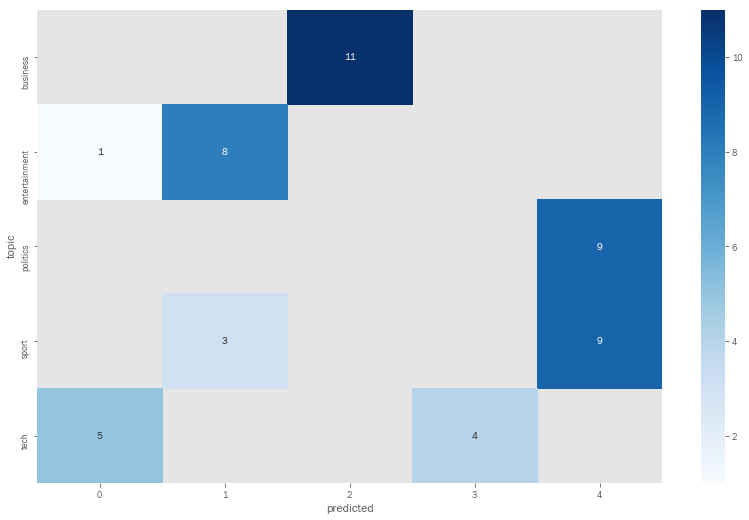

In [106]:
predictions = test_docs.topic.to_frame('topic').assign(predicted=topic_probabilities.idxmax(axis=1).values)
heatmap_data = predictions.groupby('topic').predicted.value_counts().unstack()
sns.heatmap(heatmap_data, annot=True, cmap='Blues');

## Resources

- pyLDAvis: 
    - [Talk by the Author](https://speakerdeck.com/bmabey/visualizing-topic-models) and [Paper by (original) Author](http://www.aclweb.org/anthology/W14-3110)
    - [Documentation](http://pyldavis.readthedocs.io/en/latest/index.html)
- LDA:
    - [David Blei Homepage @ Columbia](http://www.cs.columbia.edu/~blei/)
    - [Introductory Paper](http://www.cs.columbia.edu/~blei/papers/Blei2012.pdf) and [more technical review paper](http://www.cs.columbia.edu/~blei/papers/BleiLafferty2009.pdf)
    - [Blei Lab @ GitHub](https://github.com/Blei-Lab)
    
- Topic Coherence:
    - [Exploring Topic Coherence over many models and many topics](https://www.aclweb.org/anthology/D/D12/D12-1087.pdf)
    - [Paper on various Methods](http://www.aclweb.org/anthology/N10-1012)
    - [Blog Post - Overview](http://qpleple.com/topic-coherence-to-evaluate-topic-models/)
